In [1]:

import kagglehub
daveianhickey_2000_16_traffic_flow_england_scotland_wales_path = kagglehub.dataset_download('daveianhickey/2000-16-traffic-flow-england-scotland-wales')

print('Data source import complete.')


100%|██████████| 132M/132M [00:01<00:00, 99.0MB/s]

Extracting files...


Data source import complete.


**Bu projede**, 2005–2014 yılları arasında meydana gelen 1.6 milyondan fazla trafik kazasına ait veriler incelenmektedir. Analizler; kazaların dağılımını, zaman içindeki değişimini ve kazaları etkileyen temel faktörleri ortaya koymayı amaçlamaktadır.

**🗃️ Veri Setleri**
Projede kullanılan veri dosyaları:

accidents_2005_to_2007.csv

accidents_2009_to_2011.csv

accidents_2012_to_2014.csv

Her dosya, kazaya ait konum, tarih, saat, hava durumu, yol tipi, ışık durumu gibi birçok önemli bilgiyi içermektedir.

Bu analiz çalışmasıyla şu sorulara yanıt aranacaktır:

* Trafik akışının değişmesi kazaları nasıl etkiler?
* Kaza oranlarını ne artırır?
* Zaman içinde kaza oranlarını tahmin edebilir miyiz?
* Kırsal ve kentsel alanlar nasıl farklılaştı?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# CSV dosyalarının okunması
df1 = pd.read_csv(f'{daveianhickey_2000_16_traffic_flow_england_scotland_wales_path}/accidents_2005_to_2007.csv', low_memory = False)
df2 = pd.read_csv(f'{daveianhickey_2000_16_traffic_flow_england_scotland_wales_path}/accidents_2009_to_2011.csv', low_memory = False)
df3 = pd.read_csv(f'{daveianhickey_2000_16_traffic_flow_england_scotland_wales_path}/accidents_2012_to_2014.csv', low_memory = False)

#Veri seti okunurken bazı sütunlar hem sayısal hem metinsel veri içerdiğinden Pandas kararsız kalmıştır.
#Bu uyarı `low_memory=False` parametresi ile kapatılmıştır.

In [4]:
# veri setlerini birleştirme gerçekleşti
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504150 entries, 0 to 1504149
Data columns (total 33 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   Accident_Index                               1504150 non-null  object 
 1   Location_Easting_OSGR                        1504049 non-null  float64
 2   Location_Northing_OSGR                       1504049 non-null  float64
 3   Longitude                                    1504049 non-null  float64
 4   Latitude                                     1504049 non-null  float64
 5   Police_Force                                 1504150 non-null  int64  
 6   Accident_Severity                            1504150 non-null  int64  
 7   Number_of_Vehicles                           1504150 non-null  int64  
 8   Number_of_Casualties                         1504150 non-null  int64  
 9   Date                                         1

In [6]:
data = df.drop([
    'Accident_Index',
    'Location_Easting_OSGR',
    'Location_Northing_OSGR',
    'Longitude',
    'Latitude',
    'Local_Authority_(District)',
    'Local_Authority_(Highway)',
    'Junction_Detail',
    'Junction_Control',
    '2nd_Road_Class',
    '2nd_Road_Number',
    'Pedestrian_Crossing-Human_Control',
    'Pedestrian_Crossing-Physical_Facilities',
    'Special_Conditions_at_Site',
    'Carriageway_Hazards',
    'Did_Police_Officer_Attend_Scene_of_Accident',
    'LSOA_of_Accident_Location',
    '1st_Road_Number',
    '1st_Road_Class',
    'Police_Force'  ,
    'Day_of_Week'
], axis=1)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504150 entries, 0 to 1504149
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype 
---  ------                   --------------    ----- 
 0   Accident_Severity        1504150 non-null  int64 
 1   Number_of_Vehicles       1504150 non-null  int64 
 2   Number_of_Casualties     1504150 non-null  int64 
 3   Date                     1504150 non-null  object
 4   Time                     1504033 non-null  object
 5   Road_Type                1504150 non-null  object
 6   Speed_limit              1504150 non-null  int64 
 7   Light_Conditions         1504150 non-null  object
 8   Weather_Conditions       1504024 non-null  object
 9   Road_Surface_Conditions  1502192 non-null  object
 10  Urban_or_Rural_Area      1504150 non-null  int64 
 11  Year                     1504150 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 137.7+ MB


In [7]:
data.head()

,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Time,Road_Type,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Year
0,2,1,1,04/01/2005,17:42,Single carriageway,30,Daylight: Street light present,Raining without high winds,Wet/Damp,1,2005
1,3,1,1,05/01/2005,17:36,Dual carriageway,30,Darkness: Street lights present and lit,Fine without high winds,Dry,1,2005
2,3,2,1,06/01/2005,00:15,Single carriageway,30,Darkness: Street lights present and lit,Fine without high winds,Dry,1,2005
3,3,1,1,07/01/2005,10:35,Single carriageway,30,Daylight: Street light present,Fine without high winds,Dry,1,2005
4,3,1,1,10/01/2005,21:13,Single carriageway,30,Darkness: Street lighting unknown,Fine without high winds,Wet/Damp,1,2005


In [8]:
#eksik verileri bulma
data.isna().sum().sort_values(ascending=False)


,0
Road_Surface_Conditions,1958
Weather_Conditions,126
Time,117
Accident_Severity,0
Date,0
Number_of_Casualties,0
Number_of_Vehicles,0
Road_Type,0
Light_Conditions,0
Speed_limit,0


**Trafik akışının değişmesi kazaları nasıl etkiler?**

/tmp/ipython-input-9-3201208864.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Time', data=data, palette='viridis')


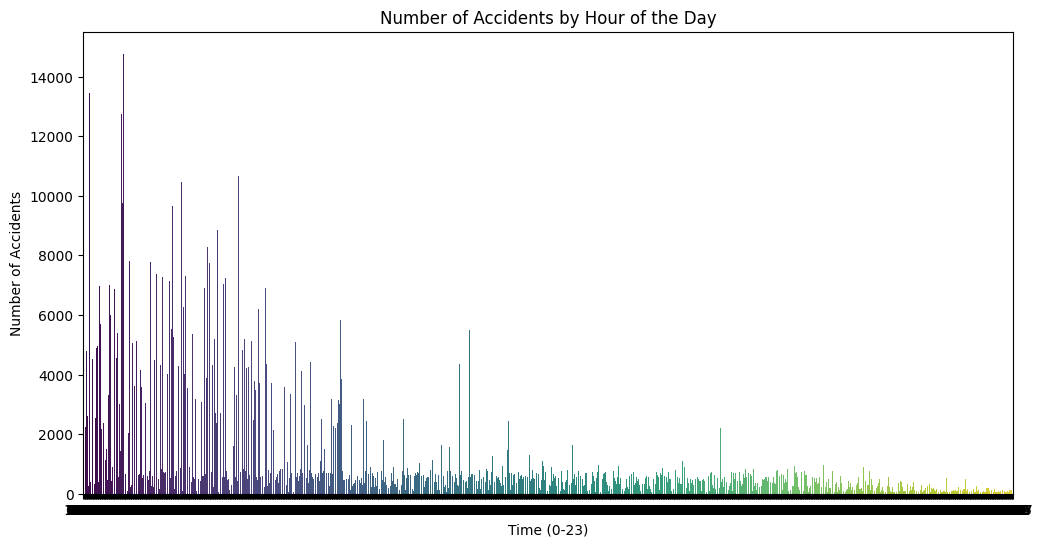

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Time', data=data, palette='viridis')
plt.title('Number of Accidents by Hour of the Day')
plt.xlabel('Time (0-23)')
plt.ylabel('Number of Accidents')
plt.show()

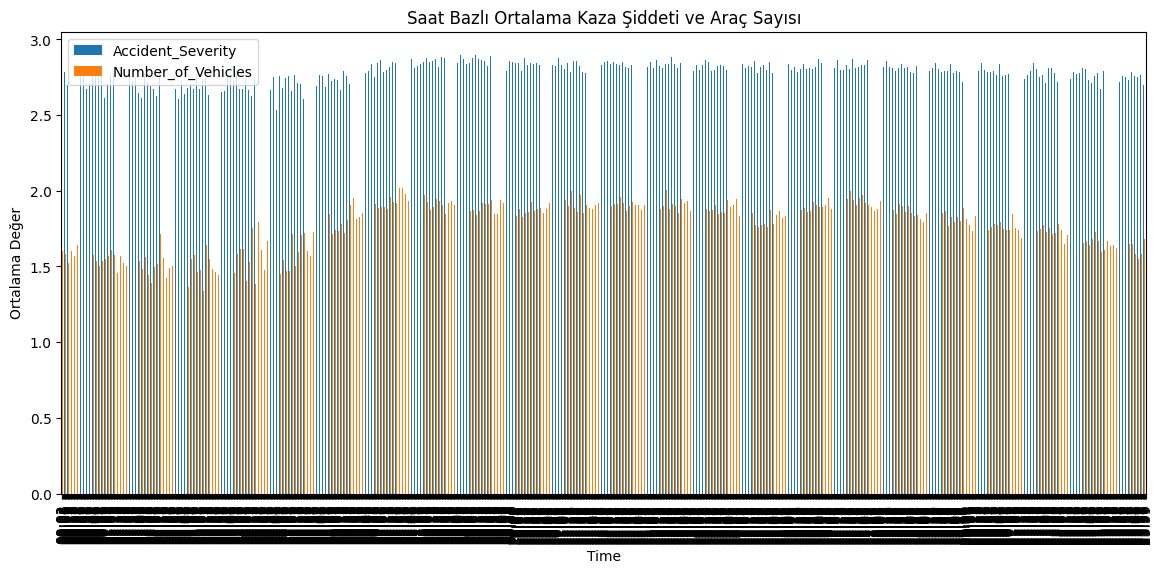

In [10]:
hourly_stats = data.groupby('Time')[['Accident_Severity', 'Number_of_Vehicles']].mean()

hourly_stats.plot(kind='bar', figsize=(14,6))
plt.title("Saat Bazlı Ortalama Kaza Şiddeti ve Araç Sayısı")
plt.ylabel("Ortalama Değer")
plt.show()


/tmp/ipython-input-11-3852417600.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Weather_Conditions', data=data, order=data['Weather_Conditions'].value_counts().index, palette='Blues_r')


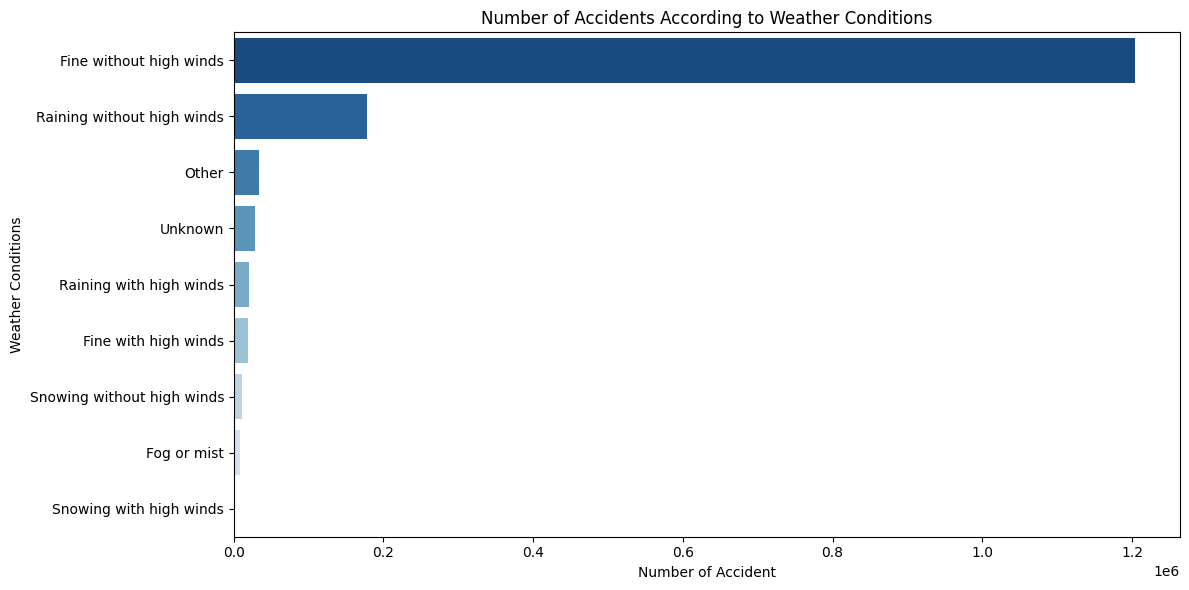

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(y='Weather_Conditions', data=data, order=data['Weather_Conditions'].value_counts().index, palette='Blues_r')
plt.title("Number of Accidents According to Weather Conditions")
plt.xlabel("Number of Accident")
plt.ylabel("Weather Conditions")
plt.tight_layout()
plt.show()

**Kaza oranlarını ne artırır?**

/tmp/ipython-input-12-4219024694.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=var, order=data[var].value_counts().index, palette='Set2')


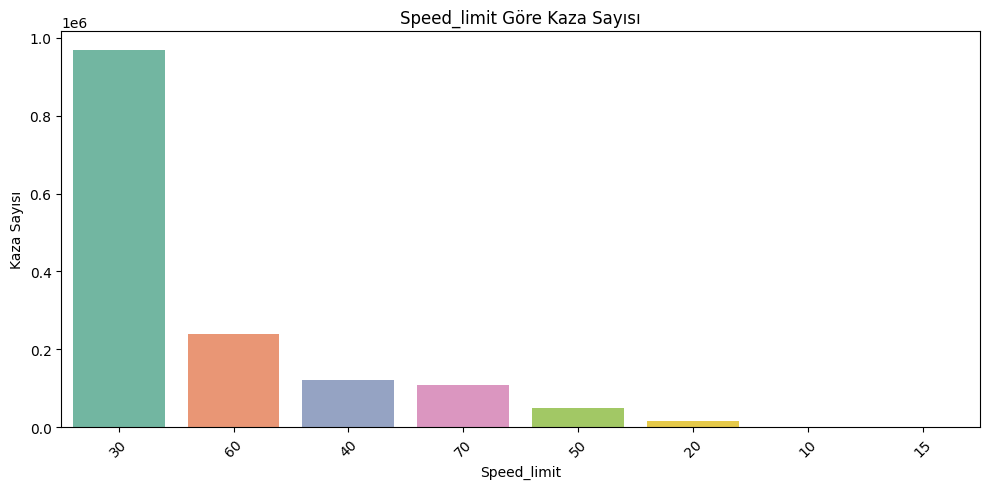

/tmp/ipython-input-12-4219024694.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=var, order=data[var].value_counts().index, palette='Set2')


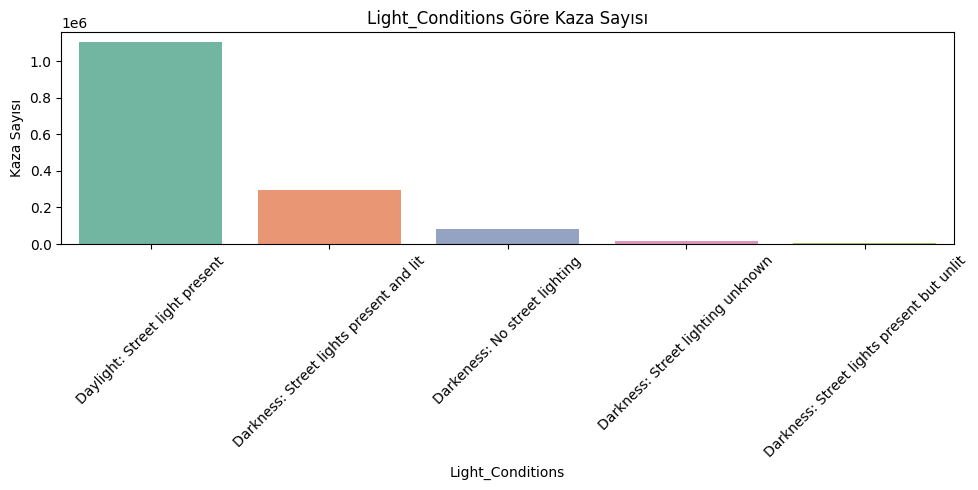

/tmp/ipython-input-12-4219024694.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=var, order=data[var].value_counts().index, palette='Set2')


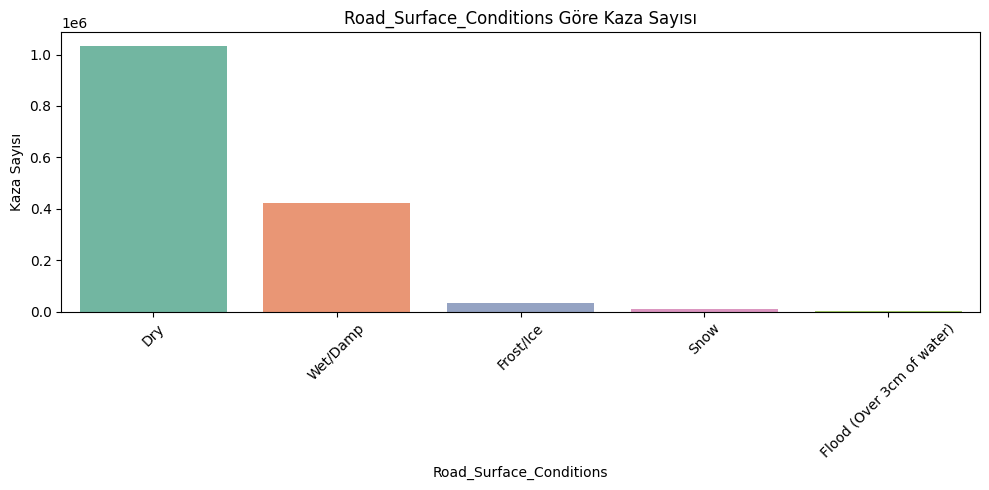

In [ ]:
categorical_vars = ['Speed_limit', 'Light_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area']

for var in categorical_vars:
    plt.figure(figsize=(10,5))
    sns.countplot(data=data, x=var, order=data[var].value_counts().index, palette='Set2')
    plt.title(f"{var} Göre Kaza Sayısı")
    plt.xticks(rotation=45)
    plt.ylabel("Kaza Sayısı")
    plt.tight_layout()
    plt.show()


**Zaman içinde kaza oranlarını tahmin edebilir miyiz?**

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y', errors='coerce')

In [ ]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Weekday'] = data['Date'].dt.day_name()
data['Month_Name'] = data['Date'].dt.month_name()

yearly = data.groupby('Year').size()

plt.figure(figsize=(10, 5))
yearly.plot(marker='o')
plt.title("Yıllara Göre Toplam Kaza Sayısı")
plt.xlabel("Yıl")
plt.ylabel("Kaza Sayısı")
plt.grid(True)
plt.show()


In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

data['Season'] = data['Month'].apply(get_season)

seasonal = data['Season'].value_counts().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

plt.figure(figsize=(8,5))
seasonal.plot(kind='bar', color='skyblue')
plt.title("Mevsimlere Göre Kaza Sayısı")
plt.ylabel("Kaza Sayısı")
plt.xlabel("Mevsim")
plt.show()


**Kırsal ve kentsel alanlar nasıl farklılaştı?**

Urban_or_Rural_Area → 1 = Şehir içi (urban), 2 = Kırsal (rural), 3 = Diğer (nadir)


In [ ]:
data['Area_Type'] = data['Urban_or_Rural_Area'].map({1: 'Urban', 2: 'Rural', 3: 'Other'})


plt.figure(figsize=(8,5))
sns.countplot(x='Area_Type', data=data, palette='Set2')
plt.title("Kırsal ve Kentsel Alanlarda Kaza Sayısı")
plt.xlabel("Alan Türü")
plt.ylabel("Kaza Sayısı")
plt.show()


In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=data, x='Road_Type', hue='Area_Type', palette='Set3')
plt.title("Yol Tipine ve Alan Türüne Göre Kaza Sayısı")
plt.xlabel("Yol Tipi")
plt.ylabel("Kaza Sayısı")
plt.xticks(rotation=45)
plt.legend(title='Alan Türü')
plt.tight_layout()
plt.show()
